In [ ]:
!pip install datasets

### Training of BLIP on Path-VQA

Importing all relevant packages

In [ ]:
from datasets import load_dataset
import torch
import io
import pickle
import pandas as pd
from transformers import BlipProcessor, BlipForQuestionAnswering
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

Preparing data for training

In [ ]:
# Load the dataset
dataset = load_dataset("flaviagiammarino/path-vqa")

# Custom dataset class
class VQADataset(torch.utils.data.Dataset):
    """VQA dataset."""

    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get question and answer
        question = self.dataframe.iloc[idx]['question']
        answer = self.dataframe.iloc[idx]['answer']
        image_bytes = self.dataframe.iloc[idx]['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Process the image and question
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")

        # Tokenize the answer
        labels = self.processor.tokenizer.encode(
            answer, max_length=8, padding="max_length", truncation=True, return_tensors='pt'
        )
        encoding["labels"] = labels
        encoding["attention_mask"] = encoding["attention_mask"]

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding

# Converting the dataset to pandas DataFrame
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()

# Filtering the yes/no questions
train_df = train_df[train_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)
val_df = val_df[val_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

Preparing the training setup

In [ ]:
# Initialize model and processor
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Empty cache and set manual seed
torch.cuda.empty_cache()
torch.manual_seed(42)

# Creating datasets and dataloaders
train_dataset = VQADataset(dataframe=train_df, processor=processor)
valid_dataset = VQADataset(dataframe=val_df, processor=processor)

batch_size = 8 # Max batch size for one A100 with 40GB VRAM
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Defining optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

# Training settings
num_epochs = 10
patience = 5
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
scaler = torch.cuda.amp.GradScaler()

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for batch in tqdm(train_dataloader, desc='Training batch: ...'):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

        loss = outputs.loss
        epoch_loss += loss.item()
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    model.eval()
    eval_loss = 0
    for batch in tqdm(valid_dataloader, desc='Validating batch: ...'):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_mask = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

        loss = outputs.loss
        eval_loss += loss.item()

    tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader)))
    scheduler.step()

    # saving model with lowest validation loss
    if eval_loss < min_eval_loss:
        model.save_pretrained("Model/blip-saved-model")
        print("Saved model to Model/blip-saved-model")
        min_eval_loss = eval_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            break

# saving training information
pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
print("The finetuning process is done!")

Plotting train and eval loss

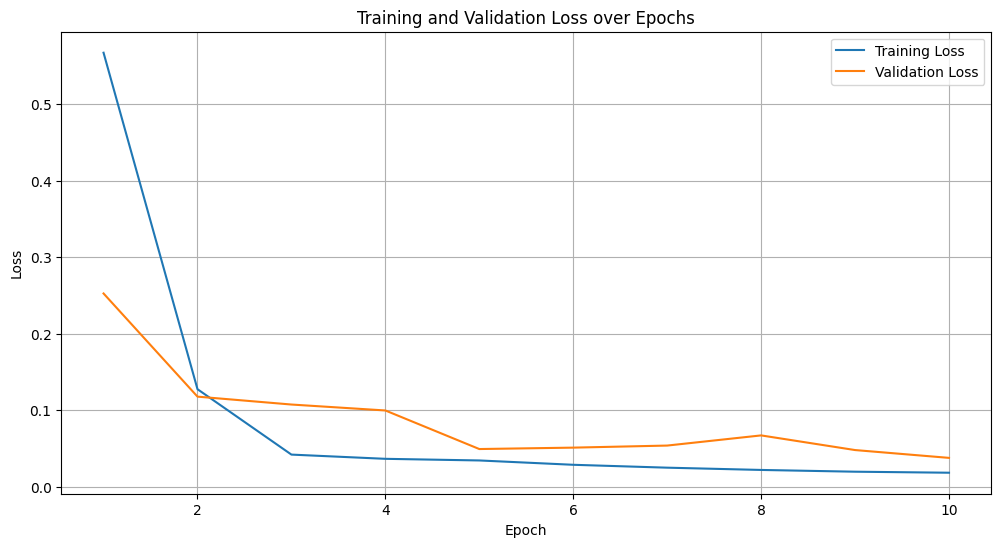

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Patho_VQA/final_tracking_information_10_e.csv")

# Extracting the training loss, validation loss, and learning rate
train_loss = df['train_loss']
val_loss = df['validation_loss']

# Plotting the training and validation loss with x-axis starting at 1
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Saving fine-tuned model

In [ ]:
model.save_pretrained("Model/blip-saved-model_final")

### Inference on Path_VQA test set

Doing inference on Path_VQA test set using the latest model and writing predictions and labels into csv.

In [ ]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import pandas as pd
import csv
import os
import torch
from tqdm import tqdm
from datasets import load_dataset
import io

# Initialize processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("/content/drive/MyDrive/Patho_VQA/blip-saved-model_final").to("cuda")

dataset = load_dataset("flaviagiammarino/path-vqa")

# Convert the test dataset to pandas DataFrame and filter yes/no answers
test_df = dataset['test'].to_pandas()
test_df = test_df[test_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

# Create a list to store the results
results = []

# Iterate through each row in the test DataFrame
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing"):
    question = row['question']
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    actual_answer = row['answer']

    # Prepare inputs
    encoding = processor(images=image, text=question, return_tensors="pt").to("cuda")

    # Perform inference
    out = model.generate(**encoding)
    generated_text = processor.decode(out[0], skip_special_tokens=True)

    # Append results using the index as the identifier
    results.append((idx, actual_answer, generated_text))

# Write the results to a CSV file
csv_file_path = "/content/drive/MyDrive/Patho_VQA/results_final.csv"
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
with open(csv_file_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["ID", "Actual Answer", "Generated Answer"])  # Write header
    csv_writer.writerows(results)

print(f"Results saved to {csv_file_path}")


### Evaluation

Evaluating test

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(csv_file_path):
    # Load the CSV file
    results_df = pd.read_csv(csv_file_path)

    # Ensure the labels are consistent
    results_df['Actual Answer'] = results_df['Actual Answer'].str.strip().str.lower()
    results_df['Generated Answer'] = results_df['Generated Answer'].str.strip().str.lower()

    # Convert answers to binary labels
    actual_labels = results_df['Actual Answer'].apply(lambda x: 1 if x == 'yes' else 0)
    generated_labels = results_df['Generated Answer'].apply(lambda x: 1 if x == 'yes' else 0)

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, generated_labels)
    precision = precision_score(actual_labels, generated_labels, zero_division=0)
    recall = recall_score(actual_labels, generated_labels, zero_division=0)
    f1 = f1_score(actual_labels, generated_labels, zero_division=0)

    return accuracy, precision, recall, f1

csv_file_path = "/content/drive/MyDrive/Patho_VQA/results_final.csv"
accuracy, precision, recall, f1 = calculate_metrics(csv_file_path)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8554
Precision: 0.8560
Recall: 0.8805
F1 Score: 0.8681


Evaluating BLIP without fine-tuning in this task

In [ ]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import pandas as pd
import csv
import os
import torch
from tqdm import tqdm
from datasets import load_dataset
import io

# Initialize processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load dataset
dataset = load_dataset("flaviagiammarino/path-vqa")

# Convert the test dataset to pandas DataFrame and filter yes/no answers
test_df = dataset['test'].to_pandas()
test_df = test_df[test_df['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)

# Create a list to store the results
results = []

# Iterate through each row in the test DataFrame
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing"):
    question = row['question']
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    actual_answer = row['answer']

    # Prepare inputs
    encoding = processor(images=image, text=question, return_tensors="pt").to(device)

    # Perform inference
    out = model.generate(**encoding)
    generated_text = processor.decode(out[0], skip_special_tokens=True)

    # Append results using the index as the identifier
    results.append((idx, actual_answer, generated_text))

# Write the results to a CSV file
csv_file_path = "results/results_no_finetuning.csv"
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
with open(csv_file_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["ID", "Actual Answer", "Generated Answer"])
    csv_writer.writerows(results)

print(f"Results saved to {csv_file_path}")

Results saved to results/results_no_finetuning.csv


In [ ]:
csv_file_path = "results/results_no_finetuning.csv"
accuracy, precision, recall, f1 = calculate_metrics(csv_file_path)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5164
Precision: 0.5344
Recall: 0.8122
F1 Score: 0.6447


### Results

The training significantly increased the capabilities of the base BLIP model in pathological visual question answering (yes/no questions).

After fine-tuning :

- Accuracy: 0.8554
- Precision: 0.8560
- Recall: 0.8805
- F1 Score: 0.8681

Before fine-tuning:

- Accuracy: 0.5164
- Precision: 0.5344
- Recall: 0.8122
- F1 Score: 0.6447

Overall improvements:

- Accuracy: 0.339
- Precision: 0.3216
- Recall: 0.0683
- F1 Score: 0.2234

Pushing model to Hugging Face Hub

In [ ]:
from huggingface_hub import notebook_login

model = BlipForQuestionAnswering.from_pretrained("/content/drive/MyDrive/Patho_VQA/blip-saved-model_final")
notebook_login()
# Push the model to the Hugging Face Hub
model.push_to_hub("slinusc/path-vqa-blip")